# Models in Neuroscience
## NSCI 801 - Quantitative Neuroscience

Gunnar Blohm

### Outline

* Models in scientific discovery
* Usefulness of models
* Model fitting


### Models in scientific discovery
Models help answering three potential types of questions about the brain (Dayan & Abbott, 2001)

* Descriptive = What? -- Compact summary of large amounts of data

* Mechanistic = How? -- Show how neural circuits perform complex function

* Interpretive = Why? -- Computations in the brain are usually performed in an optimal or nearly optimal way / Understanding optimal algorithms and their implementation to explain why the brain is designed the way it is


### Models in scientific discovery
There are different levels of models (Marr)

* Computational level - 1: what does the system do and why does it do these things
* Algorithmic level - 2: how does the system do what it does, specifically, what representations does it use and what processes does it employ to build and manipulate the representations
* Implementation level - 3: how is the system physically realised

### Models in scientific discovery
Judea Pearl (in "Book of WHY"): _"the model should depict, however qualitatively, the process that generates the data: in other words, the cause-effect forces that operate in the environment and shape the data generated."_

![Pearl](stuff/Pearl-flow.png)

### Usefulness of models

* Gain understanding
* Identify hypotheses, assumptions, unknowns
* Make quantitative predictions
* Build brain model (stroke lesions etc)
* Inspire new technologies
* Design useful experiments (i.e. animal research)

![models in science](stuff/models-in-science.png)

* [A How-to-Model Guide for Neuroscience](https://www.eneuro.org/content/7/1/ENEURO.0352-19.2019)
* [Neuromatch Academy W1D1 - model types](https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/README.md#w1d1---model-types)
* [Neuromatch Academy W1D2 - how to model](https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/README.md#w1d2---modeling-practice)
* see also the [updated how-to-model guidance from Neuromatch Academy](https://compneuro.neuromatch.io/tutorials/W1D2_ModelingPractice/W1D2_Intro.html)

### Model fitting 1 - MSE
A common method is to compute the average (mean) squared error (MSE) of the model predictions $\hat{y_i}$ for the $m$ true values $y_i$ in the data set: $$ \textrm{MSE}_{\textrm{test}} = \frac{1}{m}\sum_i(\hat{y_i}-y_i)^2$$

Let's try this...

### Model fitting 1 - MSE

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

np.random.seed(44)
plt.style.use('dark_background')

ModuleNotFoundError: No module named 'scipy'

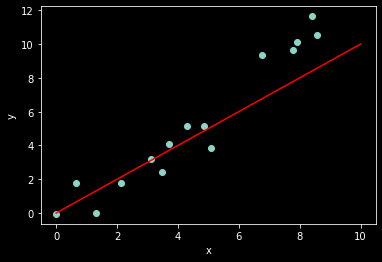

In [31]:
# (adapted from Ben Cuthbert's tutorial)
# generate some noisy data
n_samples = 15
w_true = 1.2
x = np.random.rand(n_samples)*10
noise = norm.rvs(0,1,x.shape) # the original code used uniform noise
y = w_true*x + noise

ax = plt.subplot(1,1,1) 
ax.scatter(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')

# linear regression model (just for show)
x_axis = np.linspace(0,10,20)
w = 1 # our guess for the value of w
y_hat = w*x_axis
ax.plot(x_axis, y_hat, color='red');

In order to fit a model, we first need to define our error function:

In [32]:
def compute_mse(x, y, w):
    """function that computes mean squared error"""
    y_hat = w*x
    mse = np.mean((y - y_hat)**2)
    return mse

Now let's evaluate the MSE of three different models (values of $w$)

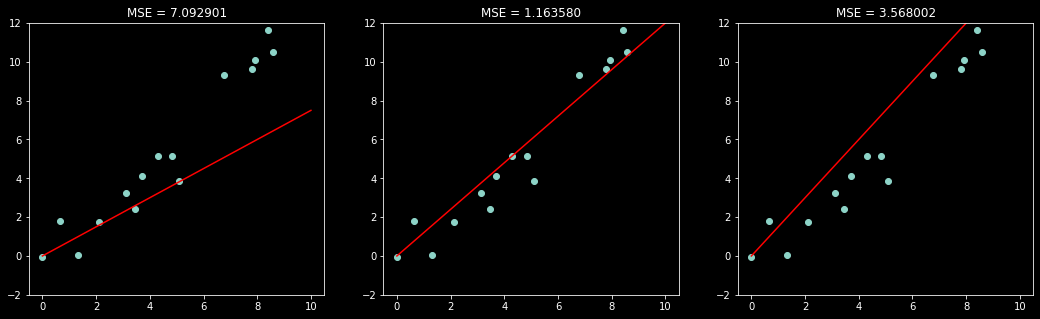

In [33]:
w = [0.75, w_true, 1.5]

fig, ax = plt.subplots(1, 3, figsize=(18,5))

for i in range(3):
    ax[i].scatter(x, y)
    ax[i].plot(x_axis, w[i]*x_axis, color='red')
    ax[i].set_ylim(-2,12)
    ax[i].set_title('MSE = %f' % compute_mse(x,y,w[ i]));

### Model fitting 1 - MSE

We still haven't answered our question: **How do we choose $w$?**

The key is to think of MSE as a **cost function**.

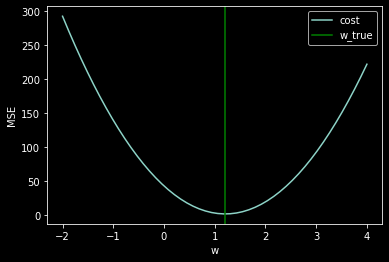

In [34]:
n_points = 50
all_w = np.linspace(-2,4,n_points)
mse = np.zeros((n_points))
for i in range(n_points):
    mse[i] = compute_mse(x, y, all_w[i])

plt.plot(all_w,mse)
plt.xlabel('w')
plt.ylabel('MSE')
plt.axvline(w_true, color='green')
plt.legend(['cost','w_true']);

How do we choose $w$? Minimize the cost function!

To minimize MSE, we solve for where its gradient is 0:

$$\nabla_w\textrm{MSE} = 0$$
$$\nabla_w\frac{1}{m}\sum_i(\hat{y_i}-y_i)^2 = 0$$
$$ ... $$
$$w = (X^TX)^{-1}X^Ty$$
This is known as solving the normal equations (see [Deep Learning](https://www.deeplearningbook.org/) 5.1.4 for more details).

In [35]:
def solve_normal_eqn(x,y):
    """Function that solves the normal equations to produce the 
    value of w that minimizes MSE"""
    
    # our numpy arrays are 0-dimensional by default- for the
    # transpose/dot product/inverse to work, we reshape them
    m = len(x)
    x = np.reshape(x, (m, 1))
    y = np.reshape(y, (m, 1))

    w = np.dot(np.dot(np.linalg.inv(x.T.dot(x)),x.T),y)
    
    return w

In [36]:
solve_normal_eqn(x,y)

array([[1.20816968]])

And we're done! We have just recovered $w$ from the noisy data by analytically computing the solution to finding the minimum of the cost function!

However this only works for very few select functions, such as linear functions...

**Thus: we need a more general way...**

### Model fitting 2 - MLE

The likelihood of the data given the model can be used directly to estimate $\theta$ through maximum likelihood estimation (MLE):
$$\hat{\theta_{MLE}}=\underset{\theta}{\operatorname{argmax}} P(D| \theta)$$

So practically, how do we do this?

### Model fitting 2 - MLE
The likelihood of the model given the data is $\mathcal{L}(\theta|D) = P(D|\theta)$

* Think of probability relating to possible results
* Think of likelihood relating to hypotheses

Here we assume Gaussian noise; the loglikelihood is thus given by:

$$\mathcal{L}(\mu, \sigma | X) = \prod_{i=1}^m\frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(x_i-\mu)^2}{2\sigma^2})$$$$\textrm{log}\mathcal{L}(\mu, \sigma | x) = \sum_{i=1}^m\textrm{log}\frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(x_i-\mu)^2}{2\sigma^2})$$

We now want to minimize the negative loglikelihood...

### Model fitting 2 - MLE
What is a likelihood?

Let's say we have a single lonely data point $x$ sampled from one of two candidate normal distributions $f_1=\mathcal{N}(\theta_1)$ and $f_2=\mathcal{N}(\theta_2)$ where $\theta_1 = \{\mu_1,\sigma_1\}$ and $\theta = \{\mu_2, \sigma_2\}$.

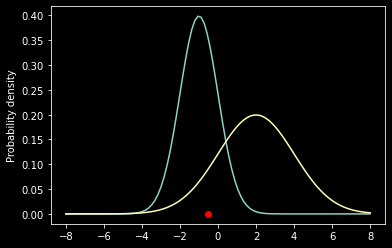

In [37]:
x = -0.5
mu1, sig1 = -1, 1
mu2, sig2 = 2, 2
x_axis = np.linspace(-8,8,100)
f1 = norm.pdf(x_axis, mu1, sig1)
f2 = norm.pdf(x_axis, mu2, sig2)

ax = plt.subplot(111)
ax.scatter(x, 0, color='red');
ax.plot(x_axis, f1);
ax.plot(x_axis, f2);
ax.set_ylabel('Probability density');

L(theta1|x) = 0.352065
L(theta2|x) = 0.091325


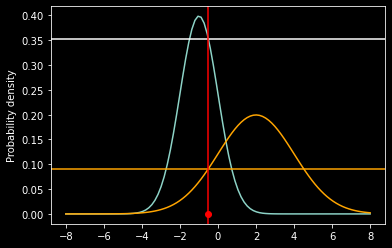

In [38]:
prob1 = norm.pdf(x, mu1, sig1)
prob2 = norm.pdf(x, mu2, sig2)
print('L(theta1|x) = %f' % prob1)
print('L(theta2|x) = %f' % prob2)

ax = plt.subplot(111)
ax.scatter(x, 0, color='red');
ax.plot(x_axis, f1);
ax.plot(x_axis, f2, color='orange');
ax.axhline(prob1)
ax.axhline(prob2, color='orange')
ax.axvline(x, color='red')
ax.set_ylabel('Probability density');

### Model fitting 2 - MLE
What if we now add a data point?

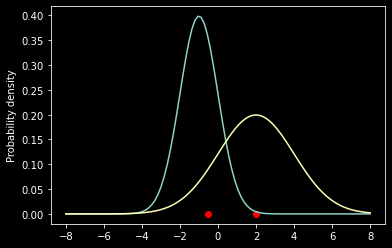

In [12]:
x = [-0.5, 2]

ax = plt.subplot(111)
ax.scatter(x, [0, 0], color='red')
ax.plot(x_axis, f1)
ax.plot(x_axis, f2)
ax.set_ylabel('Probability density')
plt.show()

In [13]:
prob1 = norm.pdf(x[0], mu1, sig1)*norm.pdf(x[1], mu1, sig1)
prob2 = norm.pdf(x[0], mu2, sig2)*norm.pdf(x[1], mu2, sig2)
print('L(theta1|x) = %f' % prob1)
print('L(theta2|x) = %f' % prob2)

L(theta1|x) = 0.001560
L(theta2|x) = 0.018217


### Model fitting 2 - MLE
Now back to our fitting problem...

We need to define our loglikelihood function:

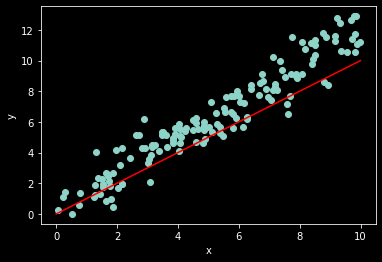

In [39]:
# generate some noisy data
n_samples = 150
w_true = 1.2
x = np.random.rand(n_samples)*10
noise = norm.rvs(0,1,x.shape) # the original code used uniform noise
y = w_true*x + noise

ax = plt.subplot(1,1,1)
ax.scatter(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')

# linear regression model (just for show)
x_axis = np.linspace(0,10,20)
w = 1 # our guess for the value of w
y_hat = w*x_axis
ax.plot(x_axis, y_hat, color='red');

In [41]:
def compute_y_hat(x, w):
    """function that computes y_hat (aka y=w0*1 + w1*x)"""
    y_hat = np.dot(x,w)
    return y_hat

In [42]:
# pad x so that matrix operation X*w gives w0 + x*w1
X = np.c_[np.ones((x.shape[0], 1)), x] 

In [43]:
# we assume the data is normally distributed around the function defined in y_hat...
def compute_nll(x, y, w):
    """function that computes the negative log likelihood of a gaussian"""
    y_hat = compute_y_hat(x, w)
    sig = np.std(y-y_hat)
    ll = -np.sum(norm.logpdf(y, y_hat, sig))
    return ll

We're now ready to minimize the loglikelihood function through adapting model parameters...

      fun: 203.6943986857902
 hess_inv: array([[ 0.02791486, -0.00426672],
       [-0.00426672,  0.00082749]])
      jac: array([1.90734863e-06, 3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([0.34100692, 1.15404339])


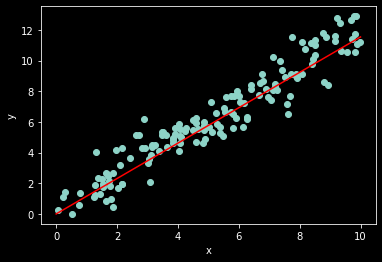

In [45]:
from scipy.optimize import minimize

# initial guess of w
w0 = np.array([0, 1])

# define a new version of our -log-likelihood that is only a function of w:
fun = lambda w: compute_nll(X, y, w)

# pass these arguments to minimize
result = minimize(fun, w0)
print(result)

# plot results
ax = plt.subplot(1,1,1)
ax.scatter(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')

# linear regression model (just for show)
x_axis = np.linspace(0,10,20)
w = result.x[1] # our guess for the value of w
y_hat = w*x_axis
ax.plot(x_axis, y_hat, color='red');

**All done!**

### Model fitting 2 - MLE
In practice, we don't want to test our model on the same data we trained it with! To avoid that we typically divide data into _training set_ and _test set_. This allows for what's called **cross-validation**. General procedure:

* draw a random subset of your data = _training data_. Remaining data = _test set_
* perform fitting procedure on _training set_ to identify model parameters
* test model performance on _test set_, e.g. compute loglikelihood of _test set_ given the identified model parameters
* do this many times...

If your training set is all but 1 data point, this is called **leave-one-out** cross-validation. 

### Model fitting - bootstrap
Bootstrapping is similar cross-validation, but the boostrap sample is chosen in a specific way to obtain meaningful statistics on the estimated parameters.

Bootstrapping is a test/metric that relies on **random sampling with replacement**. As a result, we can estimate properties of estimators (e.g. fit parameters).

**Assumption**: the limited data available is representative of the population data.

**Advantage**: no prior knowledge or assumption about the data sampling process!

### Model fitting - bootstrap
![bootstrapping](stuff/bootstrap.png)

[Toward Data Science: Intro to bootstrap](https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60)

### Model fitting - bootstrap
Bootstrap comes in handy when there is no analytical form or normal theory to help estimate the distribution of the statistics of interest, since bootstrap methods can apply to most random quantities. Here is how it works:

* randomly resample your data with replacement
* perform estimation on resampled data, e.g. compute mean, perform model fit, etc
* repeat many times, e.g. $N=1000$
* compute bootstrap distribution

Result: empirical percentiles ($\alpha$/2) of bootstrap distribution form confidence interval over parameters with confidence level $\alpha$, i.e. $(\theta^*_{\alpha/2}, \theta^*_{1-\alpha/2})$

Let's do it!

In [46]:
# generate some noisy data
n_samples = 150
w_true = 1.2
x = np.random.rand(n_samples)*10
noise = norm.rvs(0,1,x.shape) # the original code used uniform noise
y = w_true*x + 1*noise

In [49]:
boot_est = []
for _ in range(1000):
    # chose a random sample of our data with replacement
    bootind = np.random.choice(list(range(0,n_samples-1)),size=n_samples, replace=True)
    xb = x[bootind]
    yb = y[bootind]
    
    # append 1s
    Xb = np.c_[np.ones((xb.shape[0], 1)), xb]
    
    # fit model
    w0 = np.array([0, 0])
    fun = lambda w: compute_nll(Xb, yb, w)
    result = minimize(fun, w0)
    
    # save results
    boot_est.append(result.x[1])

[1.1376369217837263, 1.1958713507549792, 1.2546932636792674]
[1.1955797053496076, 0.029987463824238652]


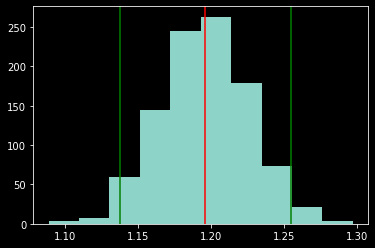

In [50]:
# plot bootstrap distribution
plt.hist(boot_est)

# confidence level
alp = 0.05

# compute percentiles
est_low = np.percentile(boot_est, 100*alp/2)
est_high = np.percentile(boot_est, 100*(1-alp/2))
est_median = np.percentile(boot_est, 50)
est_mean = np.mean(boot_est)
est_std = np.std(boot_est)

plt.axvline(est_low, color='green')
plt.axvline(est_high, color='green')
plt.axvline(est_median, color='red')

print([est_low, est_median, est_high])
print([est_mean, est_std])

### Model comparison: how to chose the best model?
* use Bayes Factor (see last lecture)
* compare MSE after k-fold cross-validation
* use Akaike's Information Criterion (AIC)

Always split your dataset into *training data* and *test data*!

### k-fold cross-validation
![x-val](stuff/grid_search_cross_validation.png)

[from scikit-learn tutorial](https://scikit-learn.org/stable/modules/cross_validation.html)

if you want to do that, check out the [from scikit-learn tutorial](https://scikit-learn.org/stable/modules/cross_validation.html) or the [Neuromatch Academy tutorial on model fitting (especially tutorial 6)](https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/README.md#w1d3---model-fitting)

### Akaike Information Criterion (AIC)
Estimates how much information would be lost if the model predictions were used instead of the true data. 

AIC strives for a good tradeoff between overfitting and underfitting by taking into account the complexity of the model and the information lost. AIC is calculated as:

$$AIC = 2K - 2\log(L)$$

with:
* K: number parameters in the model
* $\log(L)$: loglikelihood of data given your best model paremeters

Note: smallest AIC values are best! ([see Wikipedia page for more info](https://en.wikipedia.org/wiki/Akaike_information_criterion))

We can now do model comparison by computing the following relative probability that *i*th model minimizes the (estimated) information loss:

$$e^{(AIC_{min}-AIC_i)/2}$$

### Further readings
* [Neuromatch Academy W1D3 - model fitting](https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/README.md#w1d3---model-fitting)
* [Bayesian Adaptive Directed Search (BADS)](https://github.com/lacerbi/bads)